In [1]:
# import module

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
from astrodendro import analysis
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
# load data

d2800 = np.load("datasets/2800.npz")
m2800 = d2800["arr_2"]

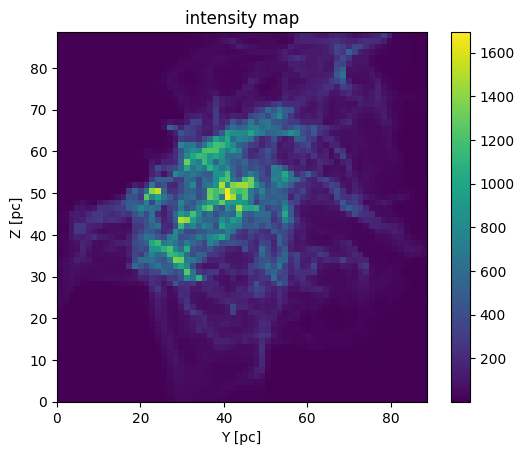

In [3]:
# make int map

int_map_2800 = np.sum(m2800, axis=0) * 0.65
pc = d2800['arr_1']
extent = [0, pc * m2800.shape[1], 0, pc * m2800.shape[2]]

fig, ax = plt.subplots()
plt.imshow(int_map_2800, extent=extent, origin='lower')
plt.title("intensity map")
ax.set_xlabel('Y [pc]')
ax.set_ylabel('Z [pc]')
plt.colorbar()

#plt.savefig("int_map_2800")

In [4]:
# compute dendrogram

dendro_2800 = Dendrogram.compute(int_map_2800, min_value=400, min_delta=150, min_npix=30)

In [5]:
# make index

leaf_indices = [i for i, structure in enumerate(dendro_2800) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro_2800) if structure.is_branch]

leaf_array = [dendro_2800[i] for i in leaf_indices]
branch_array = [dendro_2800[j] for j in branch_indices]

print('leaf_indices:', leaf_indices)
print('branch_indices:', branch_indices)

leaf_indices: [1, 2]
branch_indices: [0]


In [6]:
# check the size of leaves and branches

leaf_npix, branch_npix = [], []

for structure_index in leaf_indices:
    structure = dendro_2800[structure_index]
    npix = structure.get_npix() 
    leaf_npix.append(npix)
    
for structure_index in branch_indices:
    structure = dendro_2800[structure_index]
    npix = structure.get_npix()
    branch_npix.append(npix)
    
leaf_sizes = np.array(leaf_npix) * pc**2
branch_sizes = np.array(branch_npix) * pc**2

print('leaf_sizes:', leaf_sizes)
print('branch_sizes:', branch_sizes)

leaf_sizes: [ 76.64895058 312.3444736 ]
branch_sizes: [825.89244246]


In [7]:
# check the mass of leaves and branches

mass_per_leaf, mass_per_branch = [], []

for structure_index in leaf_indices:
    structure = dendro_2800[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    leaf_mass = np.sum(int_map_2800[indices])
    mass_per_leaf.append(leaf_mass)

for structure_index in branch_indices:
    structure = dendro_2800[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    branch_mass = np.sum(int_map_2800[indices])
    mass_per_branch.append(branch_mass)
    
mass_per_leaf_array = np.array(mass_per_leaf) / 0.65
mass_per_branch_array = np.array(mass_per_branch) / 0.65

total_mass_leaf = np.sum(mass_per_leaf_array)
total_mass_branch = np.sum(mass_per_branch_array)

print('mass_per_leaf:', mass_per_leaf_array.tolist())
print('total_mass_leaf:', total_mass_leaf)
print('mass_per_branch:', mass_per_branch_array.tolist())
print('total_mass_branch:', total_mass_branch)

mass_per_leaf: [52118.290098283826, 226889.68263337266]
total_mass_leaf: 279007.9727316565
mass_per_branch: [473164.76796248835]
total_mass_branch: 473164.76796248835


Text(0, 0.5, 'Z [pc]')

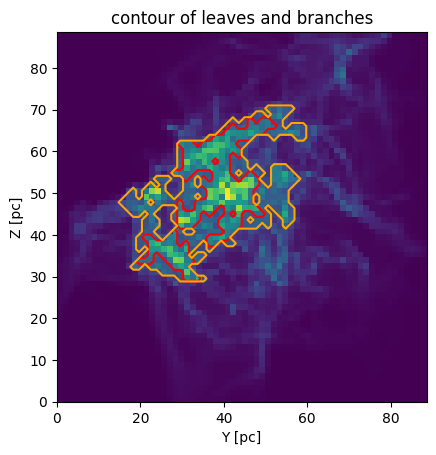

In [8]:
# plot the contour

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(int_map_2800, extent=extent, origin='lower')

p = dendro_2800.plotter()

for index_leaf in leaf_indices:
    p.plot_contour(ax, extent=extent, structure=index_leaf, colors='red')
for index_branch in branch_indices:
    p.plot_contour(ax, extent=extent, structure=index_branch, colors='orange')
    
plt.title("contour of leaves and branches")
plt.xlabel('Y [pc]')
plt.ylabel('Z [pc]')

#plt.savefig("dendro_2800_contour")

In [9]:
# make peaks list

index_list, x_peak, y_peak, peak_value = [], [], [], []
for s in dendro_2800.leaves:
    index_list.append(s.idx)
    y_ch, x_ch = s.get_peak()[0]
    value = s.get_peak()[1]
    x_peak.append(round(float(x_ch), 6))
    y_peak.append(round(float(y_ch), 6))
    peak_value.append(round(float(value), 6))
    
peak = pd.DataFrame({'id':index_list, 'x_peak':x_peak * pc, 'y_peak':y_peak * pc, 'peak_value':peak_value})

print(peak)

   id     x_peak     y_peak   peak_value
0   1  27.685547  33.222656  1366.941711
1   2  40.144043  48.449707  1693.628880


Text(0, 0.5, 'Z [pc]')

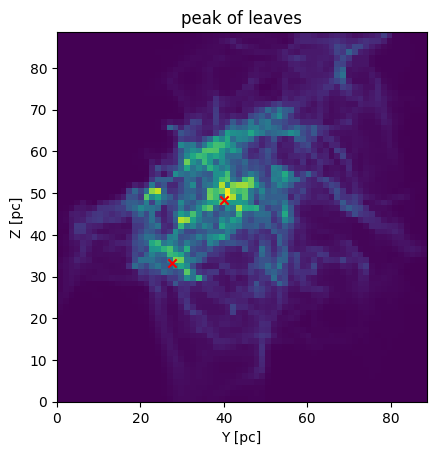

In [10]:
# plot the peaks

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(int_map_2800, extent=extent, origin='lower')

ax.scatter(peak['x_peak'], peak['y_peak'], marker='x', color='red')

plt.title('peak of leaves')
plt.xlabel('Y [pc]')
plt.ylabel('Z [pc]')

#plt.savefig('dendro_2800_peak')

In [11]:
# calculate radius

leaf_radius = np.sqrt(np.array(leaf_sizes) / np.pi)
branch_radius = np.sqrt(np.array(branch_sizes) / np.pi)

print(leaf_radius)
print(branch_radius)

[4.93944518 9.97107486]
[16.21387459]


FWHM values: [17.88541195947196]


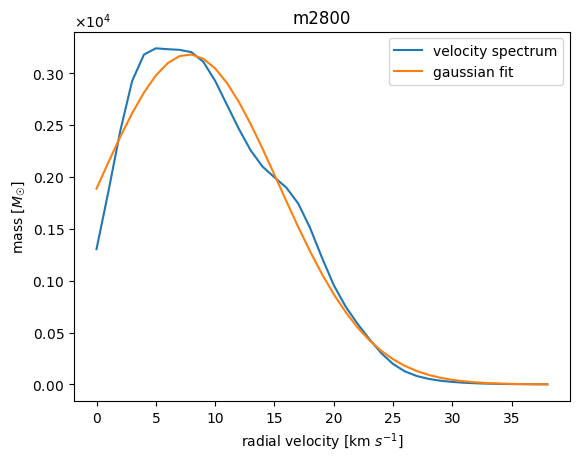

In [12]:
# sum up spectra of leaf 1 and fitting

structure = dendro_2800[leaf_indices[0]]
mask = structure.get_mask()
indices = np.where(mask)
coordinates_list = list(zip(indices[0], indices[1]))
    
spectra_list = []
for i, j in coordinates_list:
    spectra_list.append(m2800[:, i, j])
    
spe = np.sum(spectra_list, axis=0)

x_spe = np.arange(len(spe))

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

def fit_gaussian(x, *params):
    num_peaks = len(params) // 3
    result = np.zeros_like(x, dtype='float')
    for i in range(num_peaks):
        result += gaussian(x, params[i * 3], params[i * 3 + 1], params[i * 3 + 2])
    return result

num_peaks = 1
initial_params = [1, np.argmax(spe), 1] * num_peaks

params, covariance = curve_fit(fit_gaussian, x_spe, spe, p0=initial_params)

fig, ax = plt.subplots()

fit_curve = fit_gaussian(x_spe, *params)
plt.plot(x_spe, spe, label='velocity spectrum')
plt.plot(x_spe, fit_curve, label='gaussian fit')

ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci", axis="y", scilimits=(4,4))

plt.title('m2800')
plt.xlabel('radial velocity [km $s^{-1}$]')
plt.ylabel('mass [$M_☉$]')
plt.legend()

def calculate_fwhm(stddev):
    return 2 * np.sqrt(2 * np.log(2)) * stddev

fwhm_values_leaf_1 = [calculate_fwhm(params[i * 3 + 2]) for i in range(num_peaks)]
print("FWHM values:", fwhm_values_leaf_1)

#plt.savefig('fwhm_2800_leaf_1')

FWHM values: [12.573143939080957]


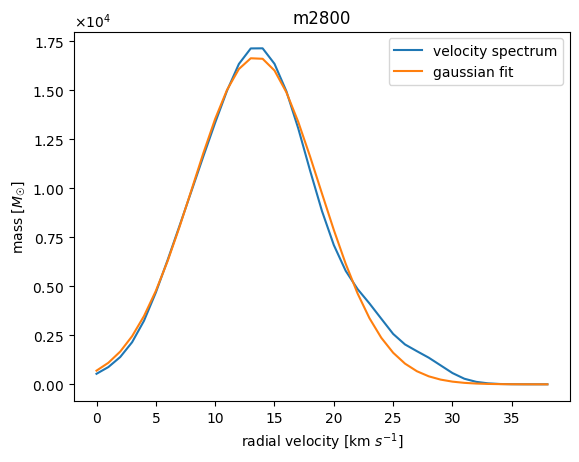

In [13]:
# sum up spectra of leaf 2 and fitting

structure = dendro_2800[leaf_indices[1]]
mask = structure.get_mask()
indices = np.where(mask)
coordinates_list = list(zip(indices[0], indices[1]))
    
spectra_list = []
for i, j in coordinates_list:
    spectra_list.append(m2800[:, i, j])
    
spe = np.sum(spectra_list, axis=0)

x_spe = np.arange(len(spe))

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

def fit_gaussian(x, *params):
    num_peaks = len(params) // 3
    result = np.zeros_like(x, dtype='float')
    for i in range(num_peaks):
        result += gaussian(x, params[i * 3], params[i * 3 + 1], params[i * 3 + 2])
    return result

num_peaks = 1
initial_params = [1, np.argmax(spe), 1] * num_peaks

params, covariance = curve_fit(fit_gaussian, x_spe, spe, p0=initial_params)

fig, ax = plt.subplots()

fit_curve = fit_gaussian(x_spe, *params)
plt.plot(x_spe, spe, label='velocity spectrum')
plt.plot(x_spe, fit_curve, label='gaussian fit')

ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci", axis="y", scilimits=(4,4))

plt.title('m2800')
plt.xlabel('radial velocity [km $s^{-1}$]')
plt.ylabel('mass [$M_☉$]')
plt.legend()

def calculate_fwhm(stddev):
    return 2 * np.sqrt(2 * np.log(2)) * stddev

fwhm_values_leaf_2 = [calculate_fwhm(params[i * 3 + 2]) for i in range(num_peaks)]
print("FWHM values:", fwhm_values_leaf_2)

#plt.savefig('fwhm_2800_leaf_2')

FWHM values: [14.187014540046329]


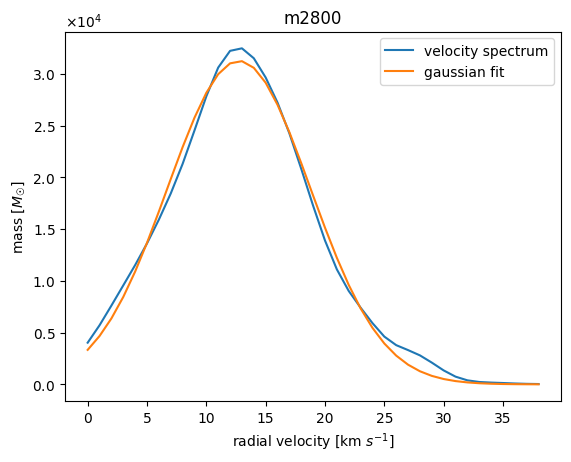

In [14]:
# sum up spectra of branch 0 and fitting

structure = dendro_2800[branch_indices[0]]
mask = structure.get_mask()
indices = np.where(mask)
coordinates_list = list(zip(indices[0], indices[1]))
    
spectra_list = []
for i, j in coordinates_list:
    spectra_list.append(m2800[:, i, j])
    
spe = np.sum(spectra_list, axis=0)

x_spe = np.arange(len(spe))

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

def fit_gaussian(x, *params):
    num_peaks = len(params) // 3
    result = np.zeros_like(x, dtype='float')
    for i in range(num_peaks):
        result += gaussian(x, params[i * 3], params[i * 3 + 1], params[i * 3 + 2])
    return result

num_peaks = 1
initial_params = [1, np.argmax(spe), 1] * num_peaks

params, covariance = curve_fit(fit_gaussian, x_spe, spe, p0=initial_params)

fig, ax = plt.subplots()

fit_curve = fit_gaussian(x_spe, *params)
plt.plot(x_spe, spe, label='velocity spectrum')
plt.plot(x_spe, fit_curve, label='gaussian fit')

ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci", axis="y", scilimits=(4,4))

plt.title('m2800')
plt.xlabel('radial velocity [km $s^{-1}$]')
plt.ylabel('mass [$M_☉$]')
plt.legend()

def calculate_fwhm(stddev):
    return 2 * np.sqrt(2 * np.log(2)) * stddev

fwhm_values_branch_0 = [calculate_fwhm(params[i * 3 + 2]) for i in range(num_peaks)]
print("FWHM values:", fwhm_values_branch_0)

#plt.savefig('fwhm_2800_branch_0')

In [15]:
# calculate velocity dispersion

delta_rv_leaf = np.array([fwhm_values_leaf_1[0], fwhm_values_leaf_2[0]])
delta_rv_branch = np.array([fwhm_values_branch_0[0]])

print(delta_rv_leaf)
print(delta_rv_branch)

[17.88541196 12.57314394]
[14.18701454]


In [16]:
# calculate virial parameter

alpha_vir_leaf = (1.2 * 10**3 * np.array(leaf_radius) * np.array(delta_rv_leaf)**2 / (3 * np.array(mass_per_leaf)))
alpha_vir_branch = (1.2 * 10**3 * np.array(branch_radius) * np.array(delta_rv_branch)**2 / (3 * np.array(mass_per_branch)))
                     
print(alpha_vir_leaf)
print(alpha_vir_branch)

[18.65660178  4.27525121]
[4.24427067]
